In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import utils.imgs as imgs

from utils.training import numpy_metrics

In [3]:
def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x),axis=axis, keepdims=True)

In [4]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
            Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

In [5]:
def view_annotated(temp, alpha=None, plot=True):
    #emp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    print(rgb.shape)
    
    if alpha is not None:
        rgb = np.append(rgb, np.expand_dims(alpha, 2), 2)
        
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

In [6]:
dropout = np.load('test_preds/dropout/dropout.npz')
#swag_cov = np.load('test_preds/swag_cov/swag_50.npz')
swag = np.load('test_preds/swag_v2/preds.npz')
swa = np.load('test_preds/sgd/swa_1000_v2.npz')
sgd = np.load('test_preds/sgd/sgd_1000.npz')

In [8]:
print( dropout['targets'].shape )
print( swa['targets'].shape )
print( sgd['targets'].shape )

print((swa['targets']==sgd['targets']).mean())
print((dropout['targets']==sgd['targets']).mean())
print((swag['targets']==dropout['targets']).mean())
#print((swag_cov['targets']==dropout['targets']).mean())
#print((swag_cov['targets']==sgd['targets']).mean())

(233, 360, 480)
(233, 360, 480)
(233, 360, 480)
1.0
1.0
1.0


## Image Views 

In [9]:
targets = dropout['targets']
preds = dropout['predictions']

(360, 480, 3)


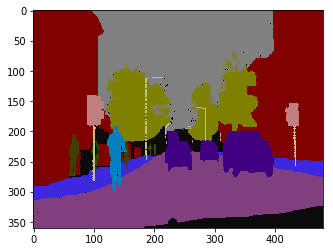

In [10]:
view_annotated(targets[0])

(360, 480, 3)


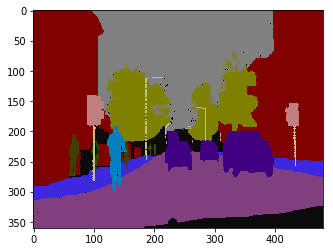

In [11]:
view_annotated(swa['targets'][0])

In [12]:
pred_image = np.argmax(preds[0],axis=0)
pred_probs = np.max(preds[0], axis=0)
rgb_drop = view_annotated(pred_image, pred_probs, plot=False)

(360, 480, 3)


In [13]:
pred_image = np.argmax(swag['predictions'][0],axis=0)
pred_probs = np.max(swag['predictions'][0], axis=0)
rgb_swag = view_annotated(pred_image, pred_probs, plot=False)

(360, 480, 3)


In [14]:
pred_image = np.argmax(swa['preds'][0],axis=0)
pred_probs = np.max(softmax(swa['preds'][0],0), axis=0)
rgb_swa = view_annotated(pred_image, pred_probs, plot=False)

(360, 480, 3)


In [15]:
pred_image = np.argmax(sgd['preds'][0],axis=0)
pred_probs = np.max(softmax(sgd['preds'][0],0), axis=0)
rgb_sgd = view_annotated(pred_image, pred_probs, plot=False)

(360, 480, 3)


(360, 480, 3)


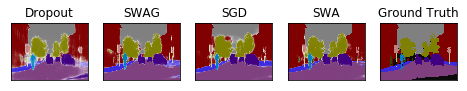

In [32]:
plt.rcParams["figure.figsize"] = (8, 72)

f, axarr = plt.subplots(1,5)
axarr[0].imshow(rgb_drop)
axarr[0].set_title('Dropout')
axarr[0].get_xaxis().set_ticks([])
axarr[0].get_yaxis().set_ticks([])

axarr[1].imshow(rgb_swag)
axarr[1].set_title('SWAG')
axarr[1].get_xaxis().set_ticks([])
axarr[1].get_yaxis().set_ticks([])

axarr[2].imshow(rgb_sgd)
axarr[2].set_title('SGD')
axarr[2].get_xaxis().set_ticks([])
axarr[2].get_yaxis().set_ticks([])

axarr[3].imshow(rgb_swa)
axarr[3].set_title('SWA')
axarr[3].get_xaxis().set_ticks([])
axarr[3].get_yaxis().set_ticks([])

axarr[4].imshow(view_annotated(targets[0], plot=False))
axarr[4].set_title('Ground Truth')
axarr[4].get_xaxis().set_ticks([])
axarr[4].get_yaxis().set_ticks([])

fig = plt.gcf()
fig.set_size_inches(8, 1.5)
plt.savefig('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/pics/segment_qual_unc.pdf')

## Calibration

In [17]:
def compute_accuracy_by_entropy(entropy, preds, labels, bins=None):
    if bins is None:
        bins = np.percentile(entropy, np.arange(100))
    digitized = np.digitize(entropy, bins)
    accuracy = [np.sum(preds[digitized==i]==labels[digitized==i])/np.sum(digitized==i) for i in range(1, len(bins))]
    return accuracy, bins

In [18]:
swag_predictions = swag['predictions']
drop_predictions = preds

swa_predictions = swa['preds']
sgd_predictions = sgd['preds']

In [19]:
#swag_cov_predictions = swag_cov['predictions']
#swag_cov_as_3d = swag_cov_predictions.reshape((targets.shape[0], 11, -1))

In [20]:
swag_as_3d = swag_predictions.reshape((targets.shape[0], 11, -1))
drop_as_3d = drop_predictions.reshape((targets.shape[0], 11, -1))

swa_as_3d = swa_predictions.reshape((targets.shape[0], 11, -1))
sgd_as_3d = sgd_predictions.reshape((targets.shape[0], 11, -1))

drop_targets = dropout['targets'].reshape((targets.shape[0], -1))
sgd_targets = sgd['targets'].reshape((targets.shape[0], -1))

swag_acc, bins = compute_accuracy_by_entropy(np.max(swag_as_3d,1), np.argmax(swag_as_3d,1), drop_targets,
                                                bins = np.arange(0.1, 1.05, 0.05))
#swag_cov_acc, bins = compute_accuracy_by_entropy(np.max(swag_cov_as_3d, 1), np.argmax(swag_cov_as_3d, 1), sgd_targets,
#                                                bins = np.arange(0.1, 1.05, 0.05))

drop_acc, bins = compute_accuracy_by_entropy(np.max(drop_as_3d,1), np.argmax(drop_as_3d,1), drop_targets,
                                                 bins = np.arange(0.1, 1.05, 0.05))

swa_acc, bins = compute_accuracy_by_entropy(np.max(softmax(swa_as_3d,1),1), np.argmax(swa_as_3d,1), sgd_targets,
                                                 bins = np.arange(0.1, 1.05, 0.05))

sgd_acc, bins = compute_accuracy_by_entropy(np.max(softmax(sgd_as_3d,1),1), np.argmax(sgd_as_3d,1), sgd_targets,
                                                 bins = np.arange(0.1, 1.05, 0.05))

/home/wesley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


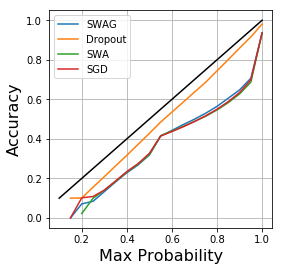

In [21]:
plt.rcParams["figure.figsize"] = (4,4)

plt.plot(bins[1:], swag_acc, label = 'SWAG')
#plt.plot(bins[1:], swag_cov_acc, label = 'SWAG')
plt.plot(bins[1:], drop_acc, label = 'Dropout')
plt.plot(bins[1:], swa_acc, label = 'SWA')
plt.plot(bins[1:], sgd_acc, label = 'SGD')
plt.plot(np.arange(0.1,1.01,.01), np.arange(0.1,1.01,.01), c='black')

plt.xlabel('Max Probability', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.grid()
plt.legend()
#plt.savefig('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/segmentation_cal.eps')

## Metrics

In [22]:
dropI, dropU, drop_acc = numpy_metrics(dropout['predictions'], dropout['targets'])
print(drop_acc)
print(np.mean(dropI / dropU))

0.9022376007118156
0.6087888665322777


In [23]:
I, U, acc = numpy_metrics(softmax(swa['preds'],1), swa['targets'])
print(acc)
print(np.mean(I / U))

0.9067085561598839
0.6227126726749744


In [24]:
I, U, acc = numpy_metrics(softmax(sgd['preds'],1), sgd['targets'])
print(acc)
print(np.mean(I / U))

0.9005122728193229
0.6172081252253548


In [25]:
swagI, swagU, swag_acc = numpy_metrics(swag['predictions'], swag['targets'])
print(swag_acc)
print(np.mean(swagI / swagU))

0.90122923316984
0.5963490447443337


In [28]:
swag['predictions'].sum(1).mean()

1.000000016309216

In [30]:
I, U, acc = numpy_metrics(swag_cov['predictions'], swag_cov['targets'])

In [ ]:
swag_targets = swag_preds['targets']
drop_targets = dropout_preds['targets']

In [ ]:
(swag_targets == drop_targets).mean()

In [94]:
def parse(npz_arr):
    return npz_arr["predictions"], npz_arr["targets"]

def ece(npz_arr, name="", bins=np.arange(0.1, 1.05, 0.05), print_name=False):
    #outputs, labels = parse(npz_arr)
    try:
        outputs, labels = npz_arr['predictions'], npz_arr['targets']
    except:
        outputs, labels = npz_arr['preds'], npz_arr['targets']
        outputs = softmax(outputs, 0)
    
    print(outputs.shape)
    if outputs is None:
        ece = None
    else:
        confidences = np.max(outputs, 1)
        predictions = np.argmax(outputs,1)
        bin_lowers = bins[:-1]
        bin_uppers = bins[1:]
        
        accuracies = predictions == labels

        #ece = Variable(torch.zeros(1)).type_as(confidences)
        ece = 0.0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = (confidences > bin_lower) * (confidences < bin_upper)
            prop_in_bin = in_bin.mean()
            if prop_in_bin > 0:
                accuracy_in_bin = accuracies[in_bin].mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin-accuracy_in_bin) * prop_in_bin
    if print_name:
        print(name, end=": ")
    if ece is not None:
        print("%.3f"%ece)
    else:
        print("-")
    return ece

In [78]:
ece(dropout, 'dropout', print_name=True)

(233, 11, 360, 480)
dropout: 0.017


0.01701972851432307

In [79]:
ece(swag, 'swag', print_name=True)

(233, 11, 360, 480)
swag: 0.087


0.08709008796333173

In [95]:
ece(sgd, 'sgd', print_name=True)

(233, 11, 360, 480)
sgd: 0.015


0.014934066682745488

In [96]:
ece(swa, 'swa', print_name=True)

(233, 11, 360, 480)
swa: 0.015


0.015151038418173186

## Entropies

In [7]:
drop_ent = dropout_preds['entropies']
swag_ent = swag_preds['entropies']

Text(0.5,1,'SWAG-Diag')

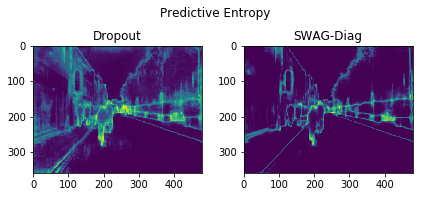

In [24]:
f, axarr = plt.subplots(1,2)
f.tight_layout()
f.subplots_adjust(top=1.25,bottom=0.0)
f.suptitle('Predictive Entropy')

axarr[0].imshow(drop_ent[0])
axarr[0].set_title('Dropout')

axarr[1].imshow(swag_ent[0])
axarr[1].set_title('SWAG-Diag')


## Mutual Information

In [7]:

for i in range(14):
    print(i)
    f_loc = 'swag_preds_testpred_'+str(i)+'.npz'
    fdict = np.load(f_loc)
    
    if i == 0:
        neg_entropies = np.sum(np.log(fdict['predictions'] + 1e-7) * fdict['predictions'], axis=1)
        predictions = fdict['predictions']
        
    else:
        neg_entropies += np.sum(np.log(fdict['predictions'] + 1e-7) * fdict['predictions'], axis=1)
        predictions += fdict['predictions']

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [8]:
predictions /= 14
neg_entropies /= 14

entropy = -np.sum(np.log(predictions + 1e-7) * predictions, axis = 1)

mutual_info = entropy + neg_entropies

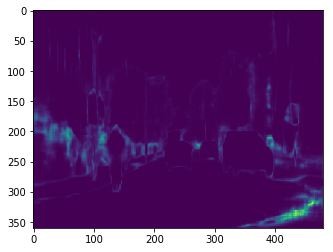

In [9]:
plt.imshow(mutual_info[0])

In [12]:
for i in range(14):
    print(i)
    f_loc = 'old_testpreds/dropout_preds_testpred_'+str(i)+'.npz'
    fdict = np.load(f_loc)
    
    if i == 0:
        dneg_entropies = np.sum(np.log(fdict['predictions'] + 1e-7) * fdict['predictions'], axis=1)
        dpredictions = fdict['predictions']
        
    else:
        dneg_entropies += np.sum(np.log(fdict['predictions'] + 1e-7) * fdict['predictions'], axis=1)
        dpredictions += fdict['predictions']

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [13]:
dpredictions /= 14
dneg_entropies /= 14

dentropy = -np.sum(np.log(dpredictions + 1e-7) * dpredictions, axis = 1)

dmutual_info = dentropy + dneg_entropies

Text(0.5,1,'Dropout')

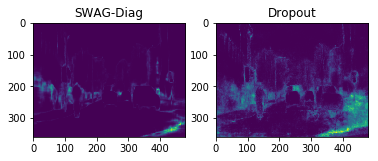

In [16]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(mutual_info[0])
axarr[0].set_title('SWAG-Diag')
axarr[1].imshow(dmutual_info[0])
axarr[1].set_title('Dropout')

In [25]:
swa['preds'].shape

(233, 11, 360, 480)